## Библиотеки

In [1]:
import json
import gzip
import pandas as pd
import numpy as np
import lightgbm as lgbm
from tqdm.notebook import tqdm
from sklearn.metrics import mean_absolute_error
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

In [2]:
tqdm.pandas()
np.random.seed(42)

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


## Считывание и приведение данных

In [4]:
with open('time_series_train.json', 'r') as f:
    data = json.load(f)

Метрика:
$$MASE = \frac{MAE}{Z}$$
Где:


$Z = 1+\frac{1}{T-1}\sum\limits_{i=2}^{T}|y(i)-y(i-1)|,\text{T - количесвто временных меток в train}$


$MAE = \frac{1}{m}\sum\limits_{i=T+1}^{T+m}|y(i)-a(i)|,\text{m - количество временных меток в test(m=3)}$


Вычислим веса для подсчёта метрики:

In [5]:
weights = []
for elem in data:
    weights.append(1 / (np.abs(np.diff([x[1] for x in elem])).mean() + 1))
weights = np.array(weights)

Заполним пропуски в данных:

* пропущенные значения внутри ряда заполним -1
* значения до начала ряда заполним -2

In [6]:
all_time_labels = []
for series in data:
    time_labels = [item[0] for item in series]
    all_time_labels.extend(time_labels)
    
data_values = np.full((len(data), max(all_time_labels) + 1), -1)
for series_index, series in enumerate(data):
    values_start = series[0][0]
    for item in series:
        data_values[series_index, item[0]] = item[1]
    data_values[series_index, : values_start] = -2

In [7]:
column_names = [i for i in range(data_values.shape[1])]
raw_data = pd.DataFrame(data=data_values, columns=column_names)
raw_data['weights'] = weights

Посмотрим на получившийся датасет:


In [8]:
raw_data.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,weights
0,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,...,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,24850,95644,0.000014
1,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,...,4,1,-1,1,1,1,1,9,3,3,2,2,2,2,2,3,3,2,2,1,1,1,2,2,1,2,2,2,7,3,3,2,3,2,2,1,2,2,2,0.487179
2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,19,4,7,...,3,6,5,4,4,4,3,3,2,2,6,8,2,2,4,1,1,2,2,2,3,2,2,2,1,2,1,1,2,3,2,1,1,2,2,8,2,1,2,0.255144
3,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,...,3,3,6,2,2,2,2,2,3,1,2,1,1,1,1,1,1,2,1,1,-1,-1,1,1,1,1,1,2,1,1,1,2,1,1,1,1,1,1,1,0.649123
4,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,...,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,0,474,23,22,18,19,22,18,17,12,15,17,18,12,12,13,0.015432


Пополним выборку данными из прошлого следующим образом.

Для каждого ряда будем случайно выбирать дату в прошлом, которую будем предсказывать. Причем для каждого ряда будем делать такой выбор несколько раз: тем больше, чем больше вес ряда.
$$N(y) = k\cdot len(y)\cdot w(y)$$

In [9]:
def get_additional_data(row, k=2):
    """
    Функция для семплирования прошлых данных из ряда.
    
    k - чем больше, тем больше рядов сэмплируем
    """
    features = row[:100].to_numpy()
    series_start = np.argmax(features > -1)
    series_len = 100 - series_start
    
    if series_len < 4:
        return None
    
    # количество сэмплов от ряда
    select_number = max(1, int(k * series_len * row['weights']))
    target_days = np.random.randint(low=series_start + 3, high=100, size=select_number)
    additional_data = np.full((select_number, len(row)), -2.)
    for index, day in enumerate(target_days):
        slice_len = day - series_start
        additional_data[index, (100 - slice_len):100] = row[series_start:day]
        
    # копируем вес ряда 
    additional_data[:, 100] = row[100]
    return additional_data

In [10]:
past_data = []
for _, row in tqdm(raw_data.iterrows(), total=raw_data.shape[0]):
    row_sclices = get_additional_data(row, k=4)
    if row_sclices is None:
        continue
    past_data.append(row_sclices)
past_data_np = np.vstack(past_data)
past_data_df = pd.DataFrame(data=past_data_np, columns=raw_data.columns)

In [11]:
data = pd.concat([raw_data, past_data_df])

Для каждой временной метки будем использовать отдельную модель(m=3)

Подберем для каждой из трех моделей, по скольки последним значениям будем делать предсказания

In [12]:
# Целевая функция по умолчанию -- rmse
params = {
    'boosting_type': 'gbdt',
    'metric': {'mae', 'mae'},
    'num_leaves': 31,
    'learning_rate': 0.1,
    'verbose': -1,
}

Функция для формирования матриц предыдущих n_days наблюдений со сдвигом на shift дней и ответа:

In [18]:
def get_past_days(data, target_day, val_day, n_days, shift):
    """
    Функция для семплирования данных из ряда.
    
    data - временные ряды
    target_day - день для предсказания(обучение) 
    val_day - день для прдесказания(валидация)
    n_days - количество дней, используемых для предсказания
    shift - лаг между последним значением и датой предсказания
    """
    first_day = target_day - shift - n_days
    last_day = target_day - 1 - shift
    features = data.iloc[:, first_day:last_day]
    
    # для инференса
    if target_day == 100:
        return features
    
    target = data.iloc[:, target_day]
    val = data.iloc[:, val_day]
    val_first_day = val_day - shift - n_days
    val_last_day = val_day - 1 - shift
    val_features = data.iloc[:, val_first_day:val_last_day]
    return features, target, val_features, val

Функция для подбора оптимального количества наблюдений для предсказания:

In [19]:
def tune_past_window(data, params, n_days_max=60):
    day_scores = {
        'day_1': {'days': [], 'metric': []},
        'day_2': {'days': [], 'metric': []},
        'day_3': {'days': [], 'metric': []}
    }
        
    for shift in range(3):
        for n_days in tqdm(range(1, n_days_max)):
            X_train, y_train, X_val, y_val  = get_past_days(
                data,
                target_day=98,
                val_day=99,
                n_days=n_days,
                shift=shift
            )
            # Учитываем веса объектов при обучении
            lgbm_train = lgbm.Dataset(X_train, y_train, weight=data['weights'])
            lgbm_eval = lgbm.Dataset(X_val, y_val)
            lgbm_reg = lgbm.train(
                params,
                lgbm_train,
                valid_sets=[lgbm_train, lgbm_eval],
                early_stopping_rounds=5,
                verbose_eval=False
            )
            score = lgbm_reg.best_score['valid_1']['l1']
            day_scores[f'day_{shift + 1}']['days'].append(n_days)
            day_scores[f'day_{shift + 1}']['metric'].append(score)

    return day_scores

Метрика качества в зависимости от количества используемых дней в прошлом

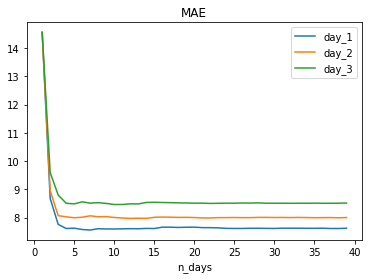

In [24]:
day_scores = tune_past_window(data, params, n_days_max=40)
plt.plot(day_scores['day_1']['days'], day_scores['day_1']['metric'], label='day_1')
plt.plot(day_scores['day_2']['days'], day_scores['day_2']['metric'], label='day_2')
plt.plot(day_scores['day_3']['days'], day_scores['day_3']['metric'], label='day_3')
plt.title('MAE')
plt.xlabel('n_days')
plt.legend()

Оптимальные параметры для каждой модели

In [25]:
days_1 = day_scores['day_1']['days'][np.argmin(day_scores['day_1']['metric'])]
days_2 = day_scores['day_2']['days'][np.argmin(day_scores['day_2']['metric'])]
days_3 = day_scores['day_3']['days'][np.argmin(day_scores['day_3']['metric'])]

print(days_1, days_2, days_3)

7 12 10


## Тюнинг параметров

In [26]:
model = lgbm.LGBMRegressor(
    boosting_type=params['boosting_type'],
    silent=True,
    num_leaves=params['num_leaves'],
    learning_rate=params['learning_rate'],
)


gridParams = {
    'learning_rate': [0.05, 0.005],
    'n_estimators': [20, 80, 100],
    'num_leaves': [150, 200, 250],
    'boosting_type' : ['gbdt'],
    'objective' : ['regression'],
    'random_state' : [501]
}

In [27]:
grid = GridSearchCV(model, gridParams, scoring='neg_mean_absolute_error', verbose=1, cv=4, n_jobs=1)

Подберем параметры обучения бустинга для модели, которая делает предсказание на один день. Эти же параметры будем использовать для остальных моделей

In [28]:
X_train_1, y_1, X_val_1, val_1 = get_past_days(
    data,
    target_day=98,
    val_day=99,
    n_days=days_1,
    shift=0
)
grid.fit(X_train_1, y_1, sample_weight=data['weights'])
print(grid.best_params_)
print(grid.best_score_)

Fitting 4 folds for each of 18 candidates, totalling 72 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed: 10.8min finished


{'boosting_type': 'gbdt', 'learning_rate': 0.05, 'n_estimators': 80, 'num_leaves': 150, 'objective': 'regression', 'random_state': 501}
-9.234794838092704


In [29]:
params['num_leaves'] = grid.best_params_['num_leaves']
params['learning_rate'] = grid.best_params_['learning_rate']
params['n_estimators'] = grid.best_params_['n_estimators']
print((params['num_leaves'], params['learning_rate'], params['n_estimators']))

(150, 0.05, 80)


## Финальное обучение

In [30]:
models = []
for i, n_days in enumerate([days_1, days_2, days_3]):
    X_train, y, _, _,  = get_past_days(data, target_day=99, val_day=99, n_days=n_days, shift=i)
    lgbm_train = lgbm.Dataset(X_train, y, weight=data['weights'])
    models.append(lgbm.train(params, lgbm_train, verbose_eval=False))

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


## Формирование ответа и оценка

In [31]:
X_1 = get_past_days(raw_data, target_day=100, val_day=100, n_days=days_1, shift=0)
pred_1 = np.maximum(0, np.round(models[0].predict(X_1)))
X_2 = get_past_days(raw_data, target_day=100, val_day=100, n_days=days_2, shift=0)
pred_2 = np.maximum(0, np.round(models[1].predict(X_2)))
X_3 = get_past_days(raw_data, target_day=100, val_day=100, n_days=days_3, shift=0)
pred_3 = np.maximum(0, np.round(models[2].predict(X_3)))
preds = np.column_stack((pred_1, pred_2, pred_3))

In [33]:
answers, labels = [], []
for series_index in range(preds.shape[0]):
    for time_label in range(preds.shape[1]):
        answers.append(preds[series_index, time_label])
        labels.append(f'{series_index}_{time_label}')
preds_df = pd.DataFrame({'Id': labels, 'Predicted': answers})
preds_df['Predicted'] = preds_df['Predicted'].astype('int')
preds_df.to_csv('submission.csv', index=False)